In [ ]:
import librosa
import librosa.display

from sklearn.model_selection import train_test_split,KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV

import math 
import matplotlib.pyplot as plt
import soundfile
import os, glob , pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support

!pip install noisereduce
!pip install pyswarms
!pip install keras-adabound

from keras_adabound import AdaBound

import noisereduce as nr
import pyswarms as ps

  Created wheel for noisereduce: filename=noisereduce-1.1.0-cp37-none-any.whl size=7610 sha256=fd7aa780b852dbbda7656186fc3ab1bb25c59d9f55e1b374ddb0449eed54cc96
  Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce
     |████████████████████████████████| 112kB 29.1MB/s 
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-cp37-none-any.whl size=6610 sha256=51cc98c7f2d7922fedb76f8260b9cf148385dc075439ea006538f44ac8765030
  Stored in directory: /root/.cache/pip/wheels/f1/81/9c/04af926d62bddd280c97af1704a9baaef511664b56865958e8
Successfully built keras-adabound


/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#Tüm Duyguları bir dictionary'e aktardık
emotions={
  0:'Normal',
  1:'Sakin',
  2:'Mutlu',
  3:'Üzgün',
  4:'Sinirli',
  5:'Korkulu',
  6:'İğrenme',
  7:'Şaşırma'
}

In [ ]:
def extract_features(file_name, noisy):
    audio_duration = 3
    sample_rate = 22050

    y, sr = librosa.load(os.path.join(file_name),res_type='kaiser_fast')
    
    if noisy:
        y = nr.reduce_noise(audio_clip=y, noise_clip=y)

    mfcc=np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40,fmin=30,fmax=2700).T,axis=0)
    return mfcc

In [ ]:
x,y = [],[]

In [ ]:
def load_data(test_size=0.2):
    global x,y
    x,y=[],[]
    print("Ravdess Datas Loading ...")
    for file in tqdm(glob.glob('/content/drive/MyDrive/Colab Notebooks/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav')):
        feature=""
        file_name=os.path.basename(file)
        
        emotion=int(file_name.split("-")[2])-1
        feature=extract_features(file,noisy=False)

        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), np.array(y), test_size=test_size, train_size= 1-test_size,random_state=42,shuffle=1)

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

Ravdess Datas Loading ...


KeyboardInterrupt: ignored

In [ ]:
import random
temp = list(zip(x, y))
random.shuffle(temp)
x, y = zip(*temp)
x = np.array(x)
print(x.shape)

#mean = np.mean(x_train, axis=0)
#std = np.std(x_train, axis=0)


#X_train = (x_train - mean)/std
#X_test = (x_test - mean)/std

(5252, 40)


In [ ]:
joblib.dump(x, os.path.join("/content/drive/MyDrive/Colab Notebooks/FeaturesLabels", "X.joblib"))
joblib.dump(y, os.path.join("/content/drive/MyDrive/Colab Notebooks/FeaturesLabels", "Y.joblib"))

['/content/drive/MyDrive/Colab Notebooks/FeaturesLabels/Y.joblib']

In [ ]:
import joblib

x = joblib.load('/content/drive/MyDrive/Colab Notebooks/FeaturesLabels/X.joblib')
y = joblib.load('/content/drive/MyDrive/Colab Notebooks/FeaturesLabels/Y.joblib')

In [ ]:
test_size = 0.2
x_train,x_test,y_train,y_test = train_test_split(np.array(x), np.array(y), test_size=test_size, train_size= 1-test_size,random_state=42,shuffle=1)

In [ ]:
x_train.shape

(4201, 40)

## Decision Tree
### -Parametresiz

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

modelDT = DecisionTreeClassifier()
modelDT.fit(x_train,y_train)
y_pred = modelDT.predict(x_test)

print(accuracy_score(y_test, y_pred))
precision_recall_fscore_support(y_test,y_pred,average="weighted")

0.698382492863939


(0.6986775653080882, 0.698382492863939, 0.6978077423985058, None)

## KNN ve GridSearchCV

In [ ]:
# Sonrasında KNN algoritmasını GridSearchCV ile taratarak
# algoritma için en iyi parametreleri araştırdık

from sklearn.model_selection import GridSearchCV

# Aranacak ve diğerleri ile kombinlenecek olan 
# Hiper parametreleri bir sözlük(dict) veri tipine aktardık 
grid_params = {
    'n_neighbors': [x for x in range(10,100,10)],
    'weights': ['uniform','distance'],
    'algorithm': ['auto'],
    'leaf_size': [2],
    'metric': ['manhattan']
}

# KNN modelimizi GridSearchCV ile oluşturduk ve parametreleri ekledik
modelKNN = GridSearchCV(KNeighborsClassifier(), grid_params, cv=10, n_jobs=-1,verbose=2)
modelKNN.fit(x_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto'], 'leaf_size': [2],
                         'metric': ['manhattan'],
                         'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
# GridSearchCV bizim için sözlüğümüzdeki
# en uygun KNN parametrelerini buldu
print(modelKNN.best_score_)
print(modelKNN.best_estimator_)
print(modelKNN.best_params_)

## KNN

In [ ]:
modelKNN = KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
modelKNN.fit(x_train,y_train)

y_pred = modelKNN.predict(x_test)

print(accuracy_score(y_test, y_pred))
precision_recall_fscore_support(y_test,y_pred,average="weighted")

0.8106565176022835


(0.8125310041967058, 0.8106565176022835, 0.8100928034628097, None)

## SVM

In [ ]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [0.001, 0.0001],
              'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,cv=10)
grid.fit(x, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.709, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.675, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.665, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.688, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.690, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.688, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.695, total=   2.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.686, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.682, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

In [ ]:
from sklearn.svm import SVC

svclassifier = SVC(gamma = 0.001 ,C = 100,kernel='rbf')
svclassifier.fit(x_train,y_train)
y_pred = svclassifier.predict(x_test)

print(accuracy_score(y_test, y_pred))
precision_recall_fscore_support(y_test,y_pred,average="weighted")

0.8553758325404377


(0.8566405126421588, 0.8553758325404377, 0.8555071520669754, None)

## MLP

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(200,),(500,),(1000,),(2000,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.05],
    'learning_rate': ['adaptive'],
}

mlp_gs = MLPClassifier(max_iter=2000)

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=10)
clf.fit(x_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (2000,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.8388451532632054


In [ ]:
print(clf.best_params_)
clf.best_score_

{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (2000,), 'learning_rate': 'adaptive', 'solver': 'adam'}


0.8388451532632054

In [ ]:
modelMLP=MLPClassifier(hidden_layer_sizes=(2000,), learning_rate='adaptive', max_iter=2000,activation='tanh',alpha=0.05,solver='adam')

modelMLP.fit(x_train,y_train)

print(accuracy_score(y_test, y_pred))
y_pred = modelMLP.predict(x_test)
precision_recall_fscore_support(y_test,y_pred,average="weighted")

0.7145575642245481


(0.7686000206505497, 0.7459562321598477, 0.7494984575859066, None)

In [ ]:
# Burada hangi duyguların hangi başarı skorlarına sahip olduklarını
# Yani modelimizin hangi duygularda daha başarılı olduğunu anlıyoruz

print(classification_report(y_test,y_pred))

## Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'n_estimators': [20, 140, 260, 380, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 43, 76, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [ ]:
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 260, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
0.8389176172370089


In [ ]:
modelRF = RandomForestClassifier(n_estimators = 260,min_samples_split=2,min_samples_leaf=1,max_features="sqrt",max_depth=None,random_state=42)
modelRF.fit(x_train,y_train)
y_pred = modelRF.predict(x_test)

print(accuracy_score(y_test, y_pred))
precision_recall_fscore_support(y_test,y_pred,average="weighted")

0.8372978116079924


(0.8473228501692681, 0.8372978116079924, 0.8384170949266735, None)

## Derin Öğrenme Teknikleri

### LSTM

In [ ]:
# Yeni boyutlarımız aşağıdaki gibidir 
x_traincnn = np.expand_dims(x_train , axis = 2)
x_testcnn = np.expand_dims(x_test , axis = 2)

x_traincnn.shape[1:]

(40, 1)

In [ ]:
# CNN için gerekli olan keras kütüphanesinden
# ihtiyacımız olanları projemize dahil ediyoruz
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,AveragePooling1D,Dense,BatchNormalization
from keras.layers import Flatten,Dropout,Activation,LSTM,TimeDistributed,ReLU
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.callbacks import  History, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [ ]:
classifier = Sequential()
#Adding the input LSTM network layer
classifier.add(LSTM(128, input_shape=x_traincnn.shape[1:], return_sequences=True))
classifier.add(Dropout(0.1))
classifier.add(LSTM(128))
classifier.add(Dropout(0.1))
classifier.add(Dense(64)) 
classifier.add(Dense(8, activation='softmax')) 
#Compiling the network
opt = optimizers.RMSprop(learning_rate=0.00001)
classifier.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'] )

#Fitting the data to the model
lstmhist = classifier.fit(x_traincnn,y_train,epochs=500,validation_data=(x_testcnn, y_test))

Epoch 1/500
132/132 [==============================] - 5s 16ms/step - loss: 2.0839 - accuracy: 0.1160 - val_loss: 2.0623 - val_accuracy: 0.1323
Epoch 2/500
132/132 [==============================] - 1s 10ms/step - loss: 2.0504 - accuracy: 0.1640 - val_loss: 2.0409 - val_accuracy: 0.1551
Epoch 3/500
132/132 [==============================] - 1s 9ms/step - loss: 2.0261 - accuracy: 0.1895 - val_loss: 2.0222 - val_accuracy: 0.1694
Epoch 4/500
132/132 [==============================] - 1s 9ms/step - loss: 2.0057 - accuracy: 0.2028 - val_loss: 2.0027 - val_accuracy: 0.1931
Epoch 5/500
132/132 [==============================] - 1s 9ms/step - loss: 1.9767 - accuracy: 0.2301 - val_loss: 1.9812 - val_accuracy: 0.2293
Epoch 6/500
132/132 [==============================] - 1s 9ms/step - loss: 1.9509 - accuracy: 0.2528 - val_loss: 1.9549 - val_accuracy: 0.2464
Epoch 7/500
132/132 [==============================] - 1s 10ms/step - loss: 1.9172 - accuracy: 0.2816 - val_loss: 1.9234 - val_accuracy: 0.2

(0.7859921273349321, 0.7792578496669839, 0.780278098608173, None)


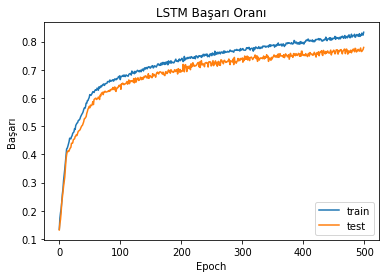

In [ ]:
y_pred = np.argmax(classifier.predict(x_testcnn),axis=-1)
print(precision_recall_fscore_support(y_test,y_pred,average="weighted"))

# Başarı oranımızın grafiği

plt.plot(lstmhist.history['accuracy'])
plt.plot(lstmhist.history['val_accuracy'])
plt.title('LSTM Başarı Oranı')
plt.ylabel('Başarı')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('accuracyLSTM.png')

### CoLSTM

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128,kernel_size=3,input_shape=x_traincnn.shape[1:],padding='same'))
model.add(BatchNormalization(name="B.Norm.1"))
model.add(Activation('relu',name="ReLU-1"))
model.add(Conv1D(filters=256,kernel_size=3,padding='same'))
model.add(BatchNormalization(name="B.Norm.2"))
model.add(Activation('relu',name="ReLU-2"))
model.add(Conv1D(filters=256,kernel_size=3,padding='same'))
model.add(BatchNormalization(name="B.Norm.3"))
model.add(Activation('relu',name="ReLU-3"))
model.add(Conv1D(filters=512,kernel_size=3,padding='same'))
model.add(BatchNormalization(name="B.Norm.4"))
model.add(Activation('relu',name="ReLU-4"))

model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(8, activation='softmax'))
#Compiling the network
opt = AdaBound(learning_rate=1e-4, final_lr=0.1)
model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
#Fitting the data to the model
model.summary()

num_epochs = 50
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=4, min_lr=0.000001, verbose=1)
cnnhistory=model.fit(x_traincnn, y_train, epochs=num_epochs,validation_data=(x_testcnn, y_test),callbacks=[lr_reduce])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 40, 128)           512       
_________________________________________________________________
B.Norm.1 (BatchNormalization (None, 40, 128)           512       
_________________________________________________________________
ReLU-1 (Activation)          (None, 40, 128)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 40, 256)           98560     
_________________________________________________________________
B.Norm.2 (BatchNormalization (None, 40, 256)           1024      
_________________________________________________________________
ReLU-2 (Activation)          (None, 40, 256)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 40, 256)         

In [ ]:
y_pred = np.argmax(model.predict(x_testcnn),axis=-1)
print(accuracy_score(y_test, y_pred))
#85.71 128 256 256 / 3 all / lr 1.4
precision_recall_fscore_support(y_test,y_pred,average="weighted")

0.8677450047573739


(0.8698254329428383, 0.8677450047573739, 0.8682402982028936, None)

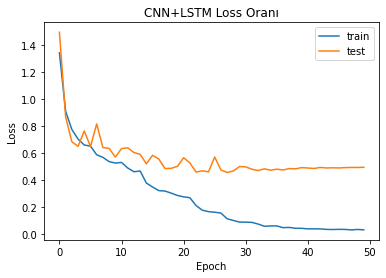

In [ ]:
# Loss oranımızın grafiği
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('CNN+LSTM Loss Oranı')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss.png')

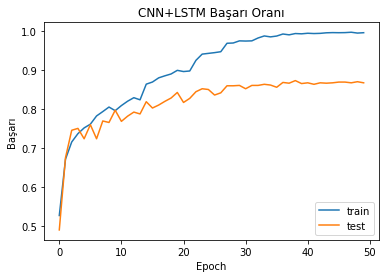

In [ ]:
# Başarı oranımızın grafiği
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('CNN+LSTM Başarı Oranı')
plt.ylabel('Başarı')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('accuracy.png')